# Imports

In [1]:
import torch
import torch.nn as nn
import einops
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation
from scipy.spatial import Voronoi, voronoi_plot_2d
from IPython.display import HTML

# Minimal code

In [2]:
class MCL_Loss(nn.Module):

    def __init__(self) -> None:
        super(MCL_Loss, self).__init__()
        self.score_metric = torch.nn.BCELoss()   

    def forward(self, prediction_list, score_list, target_list, epoch=None):
        # extract shape
        n_prediction, n_target = prediction_list.shape[1], target_list.shape[1]

        # compute pairwise distance
        pairwise_distance = -torch.square(prediction_list.unsqueeze(2)-target_list.unsqueeze(1)).sum(dim=-1)

        # assign source to closest prediction    
        mcl_sisdr, target_assignment = pairwise_distance.max(dim=1) # [batch_size, n_target], [batch_size, n_target]
        mcl_sisdr = -mcl_sisdr.mean() # []

        # compute prediction -> target assignment
        prediction_assignment = torch.stack([torch.nn.functional.one_hot(target_assignment[:,target_index], num_classes=n_prediction).float() for target_index in range(n_target)], dim=-1) # [batch_size, n_prediction, n_target]
        score_loss = self.score_metric(score_list, prediction_assignment.any(dim=-1).float()) # []

        return (mcl_sisdr, score_loss) #(mcl_sisdr, score_loss, prediction_assignment)

class Annealed_MCL_Loss(nn.Module):

    def __init__(self, temperature_schedule, min_temperature=1e-4):
        super(Annealed_MCL_Loss, self).__init__()
        self.score_metric = torch.nn.BCELoss()
        self.temperature_schedule = temperature_schedule
        self.min_temperature = min_temperature # for stability issues

    def forward(self, prediction_list, score_list, target_list, epoch=None):
        # extract shape
        n_prediction, n_target = prediction_list.shape[1], target_list.shape[1]

        # compute pairwise distance
        pairwise_distance = -torch.square(prediction_list.unsqueeze(1)-target_list.unsqueeze(2)).sum(dim=-1) # [batch_size, n_target, n_prediction]

        # soft assignation of source to closest prediction (& hard assignment for scoring purposes)
        temperature = self.temperature_schedule(epoch)
        amcl_sisdr = (torch.softmax(pairwise_distance / temperature, dim=2).detach() * pairwise_distance).sum(dim=2)  if temperature > self.min_temperature else pairwise_distance.max(dim=2)[0] # [batch_size, n_target]  
        target_assignment = pairwise_distance.max(dim=2)[1] # [batch_size, n_target]

        # mask inactive target (normalize per sample)
        target_mask = (target_list.abs().sum(dim=-1) > 0.).squeeze(-1) # [batch_size, n_target]
        amcl_sisdr = ((amcl_sisdr * target_mask).sum(dim=-1) / target_mask.sum(dim=-1)).mean() # []
        amcl_sisdr = - amcl_sisdr

        # compute prediction -> target assignment
        prediction_assignment = torch.stack([torch.nn.functional.one_hot(target_assignment[:,target_index], num_classes=n_prediction).float() for target_index in range(n_target)], dim=-1) # [batch_size, n_prediction, n_target]
        score_loss = self.score_metric(score_list, prediction_assignment.any(dim=-1).float()) # []
        
        return (amcl_sisdr, score_loss) # (amcl_sisdr, score_loss, prediction_assignment)


# Experiments on synthetic data 

## Non conditional MCL

In [9]:
# data parameters
input_dim = 2
n_cluster = 1
cluster_std = 1
batch_size = 1024

# training parameters
n_epoch = 2000
n_model = 10
loss_type = "mcl" # "mcl" or "amcl"
schedule_type = "linear" # "constant" or "linear" or "exponential"
temperature_start, max_epoch, temperature_threshold = 3, int(n_epoch * 0.5), 0.01

# model
class NonConditionalModel(nn.Module):
    def __init__(self, input_dim, n_model, batch_size):
        super(NonConditionalModel, self).__init__()
        self.prediction_list = nn.Parameter(torch.randn(n_model, input_dim), requires_grad=True)
        self.score_list = nn.Parameter(torch.randn(n_model), requires_grad=True)

    def forward(self):
        prediction_list = einops.repeat(self.prediction_list, 'n_model input_dim -> batch_size n_model input_dim', batch_size=batch_size) # [batch_size, n_model, input_dim]
        score_list = torch.sigmoid(einops.repeat(self.score_list, 'n_model -> batch_size n_model', batch_size=batch_size)) # [batch_size, n_model]
        return prediction_list, score_list
model = NonConditionalModel(input_dim, n_model, batch_size)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) # torch.optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999))

# temperature_schedule
if schedule_type == "constant":
    temperature_schedule = lambda epoch: temperature_start
elif schedule_type == "linear":
    temperature_schedule = lambda epoch : max(temperature_threshold, (temperature_start * (max_epoch - epoch) / max_epoch))
elif schedule_type == "exponential":
    temperature_schedule = lambda epoch : temperature_start * (0.9 ** epoch) if epoch < max_epoch else 0
else:
    temperature_schedule = lambda epoch: 0

# metric
training_metric = MCL_Loss() if loss_type == "mcl" else Annealed_MCL_Loss(temperature_schedule)

# data
cluster_center = torch.randn(n_cluster, input_dim)
cluster_std = torch.rand(n_cluster) * cluster_std

log_dict = defaultdict(list)
for epoch in tqdm(range(n_epoch)):
    
    # generate training data (one batch)
    cluster_index = torch.randint(0, n_cluster, (batch_size,)) # [batch_size]
    target_list = cluster_center[cluster_index] + torch.randn(batch_size, input_dim) * cluster_std[cluster_index].unsqueeze(-1) # [batch_size, input_dim]
    target_list = target_list.unsqueeze(1) # [batch_size, 1, input_dim]

    # forward
    prediction_list, score_list = model() # [batch_size, n_model, input_dim], # [batch_size, n_model, 1]

    # loss
    prediction_loss, score_loss = training_metric(prediction_list, score_list, target_list, epoch=epoch) # [], []
    loss = prediction_loss + score_loss # []

    # backward
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # log everything
    log_dict['prediction_loss'].append(prediction_loss.detach().cpu())
    log_dict['score_loss'].append(score_loss.detach().cpu())
    log_dict['loss'].append(loss.detach().cpu())
    log_dict['epoch'].append(torch.tensor(epoch))
    log_dict[f"prediction_list"].append(prediction_list.detach().cpu().clone())
    log_dict[f"score_list"].append(score_list.detach().cpu().clone())
    log_dict[f"target_list"].append(target_list.detach().cpu())

# reformat to tensor (easier to manipulate)
log_dict = {k: torch.stack(v) for k, v in log_dict.items()}

100%|██████████| 2000/2000 [00:02<00:00, 736.77it/s]


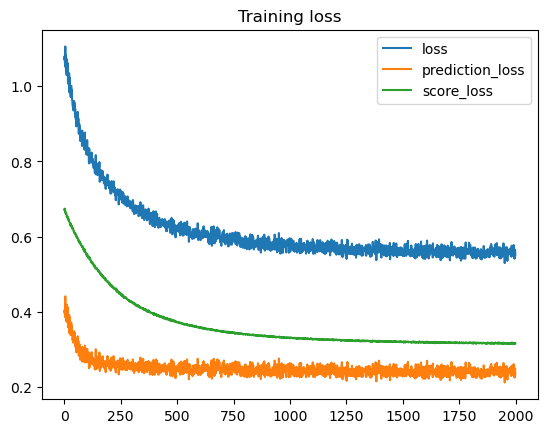

In [10]:
# plot loss
plt.title('Training loss')
plt.plot(log_dict['epoch'], log_dict['loss'], label='loss')
plt.plot(log_dict['epoch'], log_dict['prediction_loss'], label='prediction_loss')
plt.plot(log_dict['epoch'], log_dict['score_loss'], label='score_loss')
plt.legend()
plt.show()

In [11]:
n_frame = 40

fig, ax = plt.subplots()
fig.suptitle("Voronoi evolution")
x_min, x_max = min(log_dict["prediction_list"][...,0].min(), log_dict["target_list"][..., 0].min()), max(log_dict["prediction_list"][...,0].max(), log_dict["target_list"][..., 0].max())
y_min, y_max = min(log_dict["prediction_list"][...,1].min(), log_dict["target_list"][..., 1].min()), max(log_dict["prediction_list"][...,1].max(), log_dict["target_list"][..., 1].max())
frame_period = n_epoch // n_frame
def animate(i):
    frame_index = i * frame_period
    ax.cla()
    ax.scatter(log_dict["target_list"][frame_index, :, 0, 0], log_dict["target_list"][frame_index, :, 0, 1], label="data", s=0.1, c="red")
    voronoi = Voronoi(log_dict["prediction_list"][frame_index, 0, :, :])
    voronoi_plot_2d(voronoi, show_vertices=False, ax=ax, point_size=10)
    ax.set_xlim([x_min-0.1, x_max+0.1])
    ax.set_ylim([y_min-0.1, y_max+0.1])
animation = matplotlib.animation.FuncAnimation(fig, animate, frames=n_frame)
display(HTML(animation.to_jshtml()))
# animation.save(f'./voronoi.gif', writer='imagemagick', fps=1)
plt.close(fig)

In [13]:
# compute empirical variance
n_iteration = 2000

# generate centroid
prediction_list, _ = model()

error_list = torch.zeros(n_model)
for _ in tqdm(range(n_iteration)):
    # generate training data (one batch)
    cluster_index = torch.randint(0, n_cluster, (batch_size,)) # [batch_size]
    target_list = cluster_center[cluster_index] + torch.randn(batch_size, input_dim) * cluster_std[cluster_index].unsqueeze(-1) # [batch_size, input_dim]
    target_list = target_list.unsqueeze(1) # [batch_size, 1, input_dim]

    # compute error per voronoi cell
    pairwise_distance = -torch.square(prediction_list.unsqueeze(2)-target_list.unsqueeze(1)).sum(dim=-1)    
    mcl_sisdr, target_assignment = pairwise_distance.max(dim=1) # [batch_size, n_target], [batch_size, n_target]
    error_list += mcl_sisdr.mean(dim=0) # [n_target]
error_list /= n_iteration
error_list

tensor([-0.2413, -0.2413, -0.2413, -0.2413, -0.2413, -0.2413, -0.2413, -0.2413,
        -0.2413, -0.2413], grad_fn=<DivBackward0>)

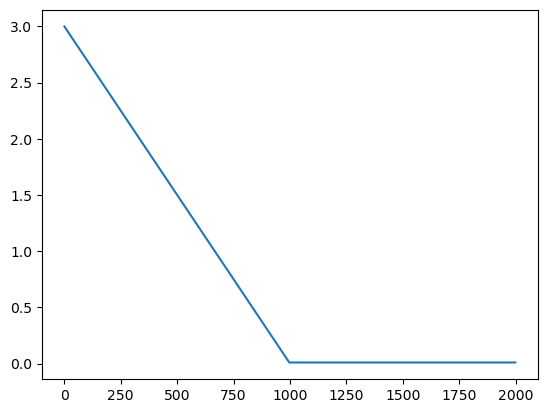

In [227]:
# display temperature schedule
plt.plot([temperature_schedule(epoch) for epoch in range(n_epoch)])